# Chunk Activation UMAP (2D/3D)

Loads per-chunk mean activation vectors from `steering_anchors_{model}.json`, loads TA-style chunk categories, and plots UMAP projections color-coded by category.

In [1]:
import os, json, math, random, gc
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# Disable Numba JIT to avoid nopython pow bug in some envs
os.environ.setdefault('NUMBA_DISABLE_JIT', '1')
try:
    import numba
    numba.config.DISABLE_JIT = True
except Exception:
    pass

# Try UMAP; fallback to sklearn if unavailable
try:
    import umap
    HAVE_UMAP = True
except Exception:
    HAVE_UMAP = False
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE

# Resolve repo root (same pattern as other notebooks)
repo_root = Path.cwd().resolve().parents[0] if (Path.cwd()).exists() else Path.cwd().resolve()
repo_root

import sys
sys.path.append(str(repo_root))

/opt/conda/envs/anchorsteering/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Config
model_name = 'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B'
model_tag = model_name.replace('/', '-')
anchors_path = repo_root / 'generated_data' / f'steering_anchors_{model_tag}.json'
categories_path = repo_root / 'generated_data' / f'chunk_categories_{model_tag}.json'
generated_path = repo_root / 'generated_data' / f'generated_data_{model_tag}.json'
output_dir = repo_root / 'generated_data' / 'figures'
output_dir.mkdir(parents=True, exist_ok=True)
anchors_path, categories_path, generated_path

(PosixPath('/home/cutterdawes/SteeringThoughtAnchors/generated_data/steering_anchors_deepseek-ai-DeepSeek-R1-Distill-Qwen-1.5B.json'),
 PosixPath('/home/cutterdawes/SteeringThoughtAnchors/generated_data/chunk_categories_deepseek-ai-DeepSeek-R1-Distill-Qwen-1.5B.json'),
 PosixPath('/home/cutterdawes/SteeringThoughtAnchors/generated_data/generated_data_deepseek-ai-DeepSeek-R1-Distill-Qwen-1.5B.json'))

## Data Sources

- Vectors: `steering_anchors_{model}.json` (per-chunk mean activations).
- Categories: `chunk_categories_{model}.json` (derived from un-annotated `generated_data_{model}.json`).
- Generated CoT: `generated_data_{model}.json` (loaded for reference and alignment).


In [ ]:
# Load data
with open(anchors_path, 'r') as f:
    anchors_payload = json.load(f)
with open(categories_path, 'r') as f:
    cats_payload = json.load(f)
with open(generated_path, 'r') as f:
    generated = json.load(f)
len(anchors_payload.get('examples', [])), len(cats_payload.get('examples', [])), len(generated)

(2, 20, 20)

In [4]:
# Load model to compute per-chunk activations when anchors are missing or incomplete
from utils import load_model_and_vectors
model, tokenizer, _ = load_model_and_vectors(model_name=model_name, compute_features=False, device=('cuda' if __import__('torch').cuda.is_available() else ('mps' if __import__('torch').backends.mps.is_available() else 'cpu')))
model.model.eval()
# Choose layer for mean activations (default: last)
try:
    layer_idx = anchors_payload.get('layer', model.config.num_hidden_layers-1)
except Exception:
    layer_idx = model.config.num_hidden_layers-1
layer_idx

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


No mean vectors found for deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B. You can save to generated_data/mean_vectors_deepseek-r1-distill-qwen-1.5b.pt.


24

In [ ]:
# TA category colors (replicated)
CATEGORY_COLORS = {
    'Active Computation': '#34A853',
    'Fact Retrieval': '#FBBC05',
    'Final Answer Emission': '#795548',
    'Plan Generation': '#EA4335',
    'Problem Setup': '#4285F4',
    'Result Consolidation': '#00BCD4',
    'Self Checking': '#FF9800',
    'Uncertainty Management': '#9C27B0'
}

def tag_to_display(tag: str) -> str:
    # Convert snake_case to Title Case to match palette keys
    s = (tag or 'unknown').replace('_', ' ').strip()
    return ' '.join([w.capitalize() for w in s.split()])

def pick_color(display_tag: str) -> str:
    if not display_tag:
        return '#9E9E9E'
    return CATEGORY_COLORS.get(display_tag, '#9E9E9E')

In [ ]:
# Build dataset: X = vectors, y = display_tag, meta = (example, chunk)
# Prefer cached anchors vectors if available for an example; otherwise compute on-the-fly from generated data.
import numpy as np
from experiments.find_steering_anchors import compute_chunk_vectors_for_example
X = []; Y = []; META = []
examples_cats = cats_payload.get('examples', [])
cat_by_idx = {e.get('example_index', i): e for i, e in enumerate(examples_cats)}
# Map example_index -> {chunk_index: vector} from anchors (if present)
anchors_map = {}
for ex_i, aex in enumerate(anchors_payload.get('examples', [])):
    anchors_map[ex_i] = {int(ch.get('chunk_index',0)): ch.get('vector', []) for ch in aex.get('chunks', [])}

for ex_i, ex in enumerate(generated):
    # Split chunks
    try:
        from utils import split_solution_into_chunks
        chunks = split_solution_into_chunks(ex.get('cot') or '')
    except Exception:
        import re
        chunks = [p.strip() for p in re.split(r'(?<=[\.\!\?])\s+|\n\n+', ex.get('cot') or '') if p.strip()]
    if not chunks:
        continue
    # Categories for this example
    cat_entry = cat_by_idx.get(ex_i, {})
    cat_map = cat_entry.get('categories', {})
    # Use cached vectors if complete; else compute
    have_all = ex_i in anchors_map and len(anchors_map[ex_i]) >= len(chunks)
    if have_all:
        for idx in range(len(chunks)):
            vec = anchors_map[ex_i].get(idx, [])
            if not vec:
                continue
            tags = cat_map.get(str(idx), {}).get('function_tags', ['unknown'])
            disp = ' '.join([w.capitalize() for w in (tags[0] if tags else 'unknown').replace('_',' ').split()])
            X.append(vec); Y.append(disp); META.append((ex_i, idx))
    else:
        # Compute vectors for this example
        res = compute_chunk_vectors_for_example(model, tokenizer, ex, layer_idx=layer_idx, device=('cuda' if __import__('torch').cuda.is_available() else ('mps' if __import__('torch').backends.mps.is_available() else 'cpu')))
        if not res:
            continue
        vec_by_idx = {int(ch['chunk_index']): ch['vector'] for ch in res.get('chunks', []) if ch.get('vector')}
        for idx in range(len(chunks)):
            vec = vec_by_idx.get(idx, None)
            if vec is None:
                continue
            tags = cat_map.get(str(idx), {}).get('function_tags', ['unknown'])
            disp = ' '.join([w.capitalize() for w in (tags[0] if tags else 'unknown').replace('_',' ').split()])
            X.append(vec); Y.append(disp); META.append((ex_i, idx))
X = np.asarray(X, dtype=np.float32); len(X), len(Y), len(META)

(507, 507, 507)

/opt/conda/envs/anchorsteering/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


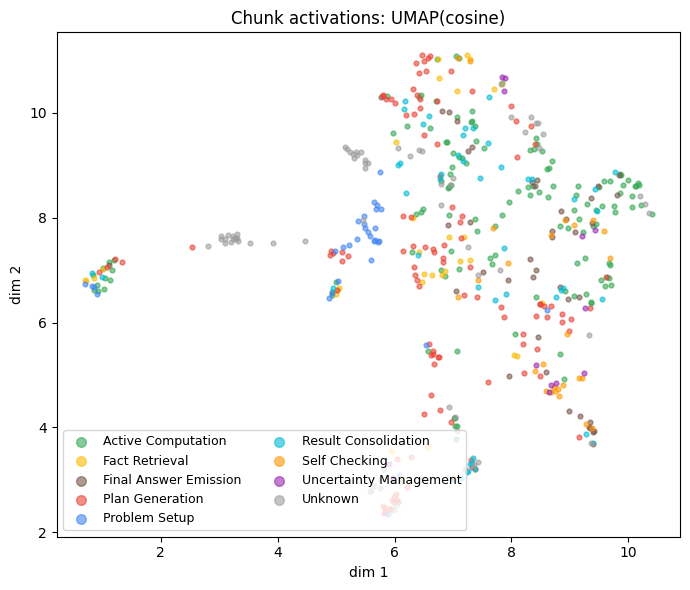

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import warnings

X_np = np.asarray(X, dtype=np.float32)
n_samples, n_dims = (X_np.shape[0] if X_np.ndim>0 else 0), (X_np.shape[1] if X_np.ndim==2 else 0)

def umap_2d_with_fallbacks(X_np):
    # Edge cases: too few samples/dims → PCA with min dims
    from sklearn.decomposition import PCA
    if X_np.ndim != 2 or X_np.shape[0] < 3 or X_np.shape[1] < 2:
        k = 2 if X_np.ndim==2 and X_np.shape[1] >= 2 else 1
        warnings.warn('Too few samples/dims for UMAP; using PCA')
        return PCA(n_components=k, random_state=42).fit_transform(X_np), f'PCA({k}D)'
    # Try UMAP (cosine) → UMAP (cosine, JIT disabled) → UMAP (precomputed) → PCA
    try:
        reducer = umap.UMAP(n_components=2, random_state=42, metric='cosine')
        return reducer.fit_transform(X_np), "UMAP(cosine)"
    except Exception as e:
        print("UMAP(cosine) failed:", e)
    try:
        import numba
        numba.config.DISABLE_JIT = True
        reducer = umap.UMAP(n_components=2, random_state=42, metric='cosine')
        out = reducer.fit_transform(X_np)
        print("Recovered with numba JIT disabled.")
        return out, "UMAP(cosine, JIT disabled)"
    except Exception as e:
        print("UMAP(cosine, JIT disabled) failed:", e)
    try:
        from sklearn.metrics import pairwise_distances
        D = pairwise_distances(X_np, metric='cosine')
        reducer = umap.UMAP(n_components=2, random_state=42, metric='precomputed')
        out = reducer.fit_transform(D)
        print("Recovered with precomputed cosine distances.")
        return out, "UMAP(precomputed cosine)"
    except Exception as e:
        print("UMAP(precomputed) failed:", e)
    print("Falling back to PCA(2D).")
    return PCA(n_components=2, random_state=42).fit_transform(X_np), "PCA(2D)"

if HAVE_UMAP:
    X2, method2 = umap_2d_with_fallbacks(X_np)
else:
    from sklearn.decomposition import PCA
    X2, method2 = PCA(n_components=min(2, max(1, n_dims)), random_state=42).fit_transform(X_np), f'PCA({min(2, max(1, n_dims))}D)'

plt.figure(figsize=(7,6))
for cls in sorted(set(Y)):
    mask = np.array([y == cls for y in Y])
    color = pick_color(cls)
    plt.scatter(X2[mask,0], X2[mask,1], s=12, alpha=0.6, c=color, label=cls)
plt.legend(markerscale=2, fontsize=9, ncol=2)
plt.title(f'Chunk activations: {method2}')
plt.xlabel('dim 1'); plt.ylabel('dim 2')
plt.tight_layout(); plt.show()

/opt/conda/envs/anchorsteering/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


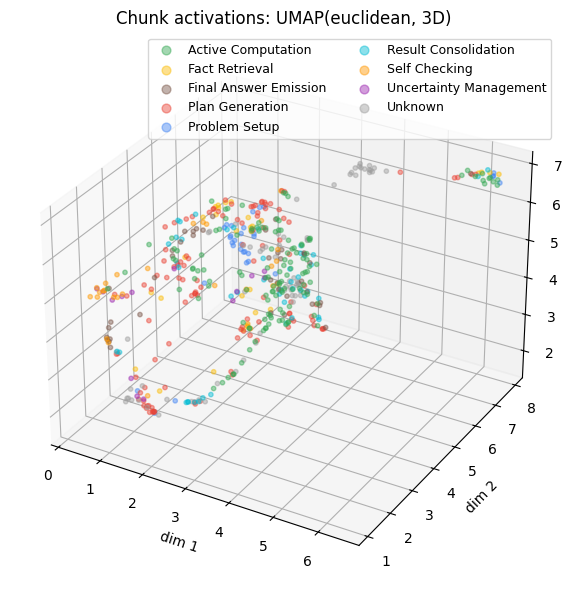

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import warnings

# Ensure numpy array
X_np = np.asarray(X, dtype=np.float32)
n_samples, n_dims = (X_np.shape[0] if X_np.ndim>0 else 0), (X_np.shape[1] if X_np.ndim==2 else 0)

# Normalize vectors so euclidean ~= cosine (monotonic) on unit sphere
norms = (np.linalg.norm(X_np, axis=1, keepdims=True) + 1e-12) if n_samples>0 else 1.0
X_unit = X_np / norms

def embedding_3d_with_fallbacks(X_unit):
    # Edge cases: too few samples/dims → PCA with min dims
    from sklearn.decomposition import PCA
    if X_unit.ndim != 2 or X_unit.shape[0] < 5 or X_unit.shape[1] < 3:
        k = min(3, max(1, X_unit.shape[1] if X_unit.ndim==2 else 1))
        warnings.warn('Too few samples/dims for UMAP/TSNE; using PCA')
        return PCA(n_components=k, random_state=42).fit_transform(X_unit), f'PCA({k}D)'
    # 1) Prefer UMAP with Euclidean (robust; avoids numba cosine path)
    if HAVE_UMAP:
        try:
            reducer = umap.UMAP(n_components=3, random_state=42, metric='euclidean')
            out = reducer.fit_transform(X_unit)
            return out, "UMAP(euclidean, 3D)"
        except Exception as e:
            print("UMAP(euclidean, 3D) failed:", e)
        # 2) Try precomputed cosine distances
        try:
            from sklearn.metrics import pairwise_distances
            D = pairwise_distances(X_unit, metric='cosine')
            reducer = umap.UMAP(n_components=3, random_state=42, metric='precomputed')
            out = reducer.fit_transform(D)
            print("Recovered with precomputed cosine distances.")
            return out, "UMAP(precomputed cosine, 3D)"
        except Exception as e:
            print("UMAP(precomputed, 3D) failed:", e)
    # 3) Fall back to t-SNE (safe perplexity), then PCA
    try:
        from sklearn.manifold import TSNE
        # Ensure perplexity < n_samples and at least 2
        perp = max(2, min(30, X_unit.shape[0]//3))
        out = TSNE(n_components=3, random_state=42, init='pca', learning_rate='auto', perplexity=perp).fit_transform(X_unit)
        return out, "TSNE(3D)"
    except Exception as e:
        print("TSNE(3D) failed:", e)
        from sklearn.decomposition import PCA
        out = PCA(n_components=min(3, max(1, X_unit.shape[1])), random_state=42).fit_transform(X_unit)
        return out, f'PCA({min(3, max(1, X_unit.shape[1]))}D)'

X3, method3 = embedding_3d_with_fallbacks(X_unit)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
for cls in sorted(set(Y)):
    mask = np.array([y == cls for y in Y])
    color = pick_color(cls)
    ax.scatter(X3[mask,0], X3[mask,1], X3[mask,2], s=10, alpha=0.45, c=color, label=cls)
ax.set_title(f'Chunk activations: {method3}')
ax.set_xlabel('dim 1'); ax.set_ylabel('dim 2'); ax.set_zlabel('dim 3')
plt.legend(markerscale=2, fontsize=9, ncol=2)
plt.tight_layout(); plt.show()